<a href="https://colab.research.google.com/github/Jaksta1/Uczenie_Maszynowe_2025/blob/main/Jakub_Kownacki_praca_domowa_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------
#1.Wybór i załadowanie danych
------------------------------------------
Do badania tematu optymalnego progu w regresji logistycznej użyjemy danych "breast cancer" z biblioteki sklearn.datasets.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

data = load_breast_cancer()

df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

print(df.head())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

Ten zbiór danych składa się z 30 kolumn opisujących parametry medyczne pacjentów, ostatnia kolumna mówi o tym, czy rak jest złośliwy - 0 czy łagodny - 1. Użyjemy ich do przeprowadzenia regresji logistycznej i odpowiedzi na pytania postawione w zadaniu.

In [2]:
X = data.data
y = data.target

-----------------------------------------
#2. Podział danych na zbiór treningowy, walidacyjny i testowy oraz trening modelu regresji logistycznej na danych treningowych
-----------------------------------------

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = LogisticRegression(max_iter=1000000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000000)

-----------------------------------------
# 3.Predykcja na zbiorze walidacyjnym, wyznaczenie krzywej ROC i obliczenie AUC
-----------------------------------------

In [4]:
y_val_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)  # Krzywa ROC
roc_auc = auc(fpr, tpr)  # Obliczenie AUC

--------------------------------------
# 4.Znalezienie optymalnego progu i estymacja FPR i TPR dla wybranych progów
--------------------------------------

In [5]:
# Wyznaczenie optymalnego progu według statystyki Youdena
optimal_idx_youden = np.argmax(tpr - fpr)
optimal_threshold_youden = thresholds[optimal_idx_youden]

# Wyznaczenie optymalnego progu według odległości euklidesowej od (0,1)

distances = np.sqrt((1 - np.array(tpr))**2 + np.array(fpr)**2)
optimal_idx_euc = np.argmin(distances)
optimal_threshold_euc = thresholds[optimal_idx_euc]

# Lista wybranych progów decyzyjnych
selected_thresholds = [0.01, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.95]

# Funkcja do obliczania FPR i TPR dla danego progu
def calculate_fpr_tpr(y_true, y_pred_proba, threshold):
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)  # False Positive Rate
    tpr = tp / (tp + fn)  # True Positive Rate (Sensitivity)
    return fpr, tpr

# Obliczenie FPR i TPR dla wybranych progów
selected_fpr = []
selected_tpr = []
for thresh in selected_thresholds:
    fpr_val, tpr_val = calculate_fpr_tpr(y_val, y_val_pred_proba, thresh)
    selected_fpr.append(fpr_val)
    selected_tpr.append(tpr_val)



-----------------------------------
#5. Rysowanie krzywej ROC oraz zaznaczenie poszczególnych progów
----------------------------------

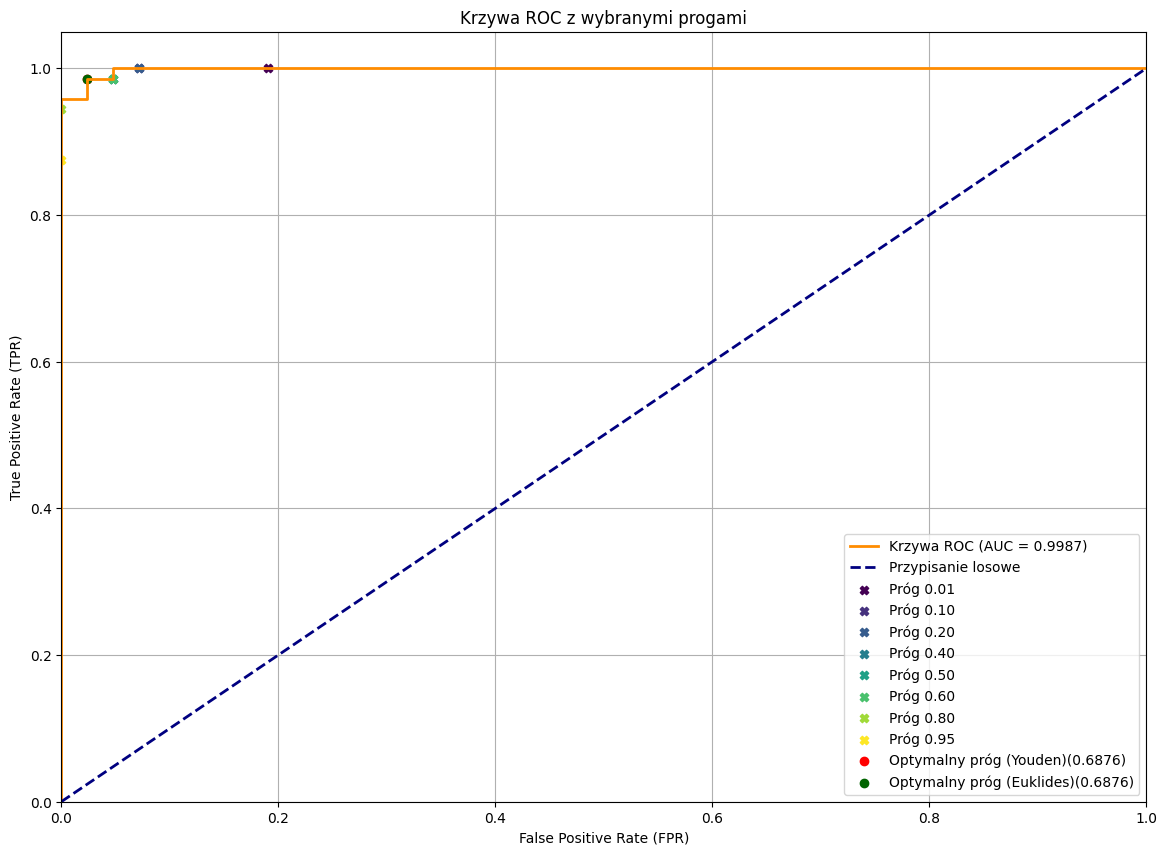

In [6]:
# Rysowanie wykresu ROC
plt.figure(figsize=(14, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Przypisanie losowe')

import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, len(selected_thresholds)))

# Rysowanie punktów dla każdego progu
for i, (thresh, fpr_val, tpr_val) in enumerate(zip(selected_thresholds, selected_fpr, selected_tpr)):
    plt.scatter(fpr_val, tpr_val, marker='X', color=colors[i], label=f'Próg {thresh:.2f}')
# Zaznaczenie optymalnego progu (statystyka Youdena i odległość euklidesowa)
plt.scatter(fpr[optimal_idx_youden], tpr[optimal_idx_youden], marker='o', color='red',
            label=f'Optymalny próg (Youden)({optimal_threshold_youden:.4f})')
plt.scatter(fpr[optimal_idx_euc], tpr[optimal_idx_euc], marker='o', color='darkgreen',
            label=f'Optymalny próg (Euklides)({optimal_threshold_euc:.4f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Krzywa ROC z wybranymi progami')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

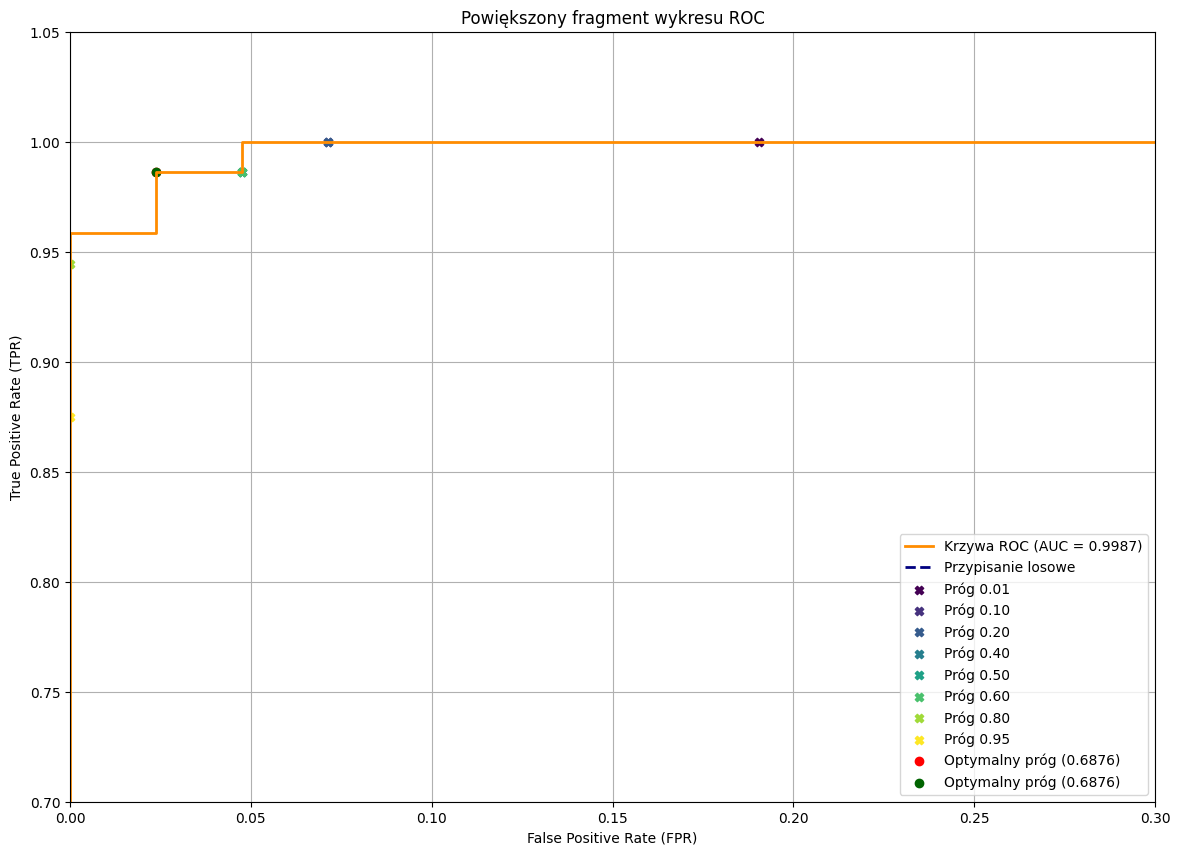

In [7]:
fig, ax = plt.subplots(figsize=(14, 10))

# Rysowanie wykresu ROC
ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.4f})')
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Przypisanie losowe')

# Rysowanie punktów dla każdego progu
for i, (thresh, fpr_val, tpr_val) in enumerate(zip(selected_thresholds, selected_fpr, selected_tpr)):
    plt.scatter(fpr_val, tpr_val, marker='X', color=colors[i], label=f'Próg {thresh:.2f}')

# Zaznaczenie optymalnego progu (statystyka Youdena i odległość euklidesowa)
ax.scatter(fpr[optimal_idx_youden], tpr[optimal_idx_youden], marker='o', color='red',
            label=f'Optymalny próg ({optimal_threshold_youden:.4f})')
ax.scatter(fpr[optimal_idx_euc], tpr[optimal_idx_euc], marker='o', color='darkgreen',
            label=f'Optymalny próg ({optimal_threshold_euc:.4f})')

# Ustawienie widocznego fragmentu (lewy górny róg)
ax.set_xlim(0.0, 0.3)
ax.set_ylim(0.7, 1.05)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Powiększony fragment wykresu ROC')
ax.legend(loc="lower right")
ax.grid(True)

plt.show()

Jak widać na obydwu wykresach optymalne progi pokrywają się i znajdują się najbliżej lewego górnego rogu wykresu. Można odczytać z legendy, że optymalne progi w obu przypadkach to około 0.6876, zatem automatyczne ustalenie progu na poziomie 0.5 byłoby nieodpowiednie dla tych danych. Niestety w przypadku tych danych widać, że niektóre wybrane progi się pokrywają, dlatego stwórzmy tabelę wyników poszczególnych wskaźników dla każdego progu.

---------------------------------------
# 6. Tabela wyników
--------------------------------------

In [8]:
results = []
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
for thresh in selected_thresholds:
    # Predykcja przy danym progu
    y_pred = (y_test_pred_proba >= thresh).astype(int)

    # Obliczenie metryk
    acc   = accuracy_score(y_test, y_pred)
    prec  = precision_score(y_test, y_pred, zero_division=0)
    rec   = recall_score(y_test, y_pred, zero_division=0)
    f1    = f1_score(y_test, y_pred, zero_division=0)

    # Macierz pomyłek: [[TN, FP], [FN, TP]]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Specificity = TN / (TN + FP)
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0

    results.append({
        'Threshold': thresh,
        'Accuracy': acc,
        'Precision': prec,
        'F1-Score': f1,
        'Specificity': spec,
        'Recall (Sensitivity)': rec
    })

# Obliczenia dla optymalnego progu (youdena)
y_pred_optimal_youden = (y_test_pred_proba >= optimal_threshold_youden).astype(int)
acc_opt_youden   = accuracy_score(y_test, y_pred_optimal_youden)
prec_opt_youden  = precision_score(y_test, y_pred_optimal_youden, zero_division=0)
rec_opt_youden   = recall_score(y_test, y_pred_optimal_youden, zero_division=0)
f1_opt_youden    = f1_score(y_test, y_pred_optimal_youden, zero_division=0)
tn_opt_youden, fp_opt_youden, fn_opt_youden, tp_opt_youden = confusion_matrix(y_test, y_pred_optimal_youden).ravel()
spec_opt_youden = tn_opt_youden / (tn_opt_youden + fp_opt_youden) if (tn_opt_youden + fp_opt_youden) > 0 else 0
results.append({
    'Threshold': optimal_threshold_youden,
    'Accuracy': acc_opt_youden,
    'Precision': prec_opt_youden,
    'Recall (Sensitivity)': rec_opt_youden,
    'F1-Score': f1_opt_youden,
    'Specificity': spec_opt_youden
})
# Obliczenia dla optymalnego progu (odległość euklidesowa)
y_pred_optimal_euc = (y_test_pred_proba >= optimal_threshold_euc).astype(int)
acc_opt_euc  = accuracy_score(y_test, y_pred_optimal_euc)
prec_opt_euc  = precision_score(y_test, y_pred_optimal_euc, zero_division=0)
rec_opt_euc   = recall_score(y_test, y_pred_optimal_euc, zero_division=0)
f1_opt_euc    = f1_score(y_test, y_pred_optimal_euc, zero_division=0)
tn_opt_euc, fp_opt_euc, fn_opt_euc, tp_opt_euc = confusion_matrix(y_test, y_pred_optimal_euc).ravel()
spec_opt_euc = tn_opt_euc / (tn_opt_euc + fp_opt_euc) if (tn_opt_euc + fp_opt_euc) > 0 else 0
results.append({
    'Threshold': optimal_threshold_euc,
    'Accuracy': acc_opt_euc,
    'Precision': prec_opt_euc,
    'Recall (Sensitivity)': rec_opt_euc,
    'F1-Score': f1_opt_euc,
    'Specificity': spec_opt_euc
})

# Tworzenie tabeli wyników
results_df = pd.DataFrame(results)
results_df

,Threshold,Accuracy,Precision,F1-Score,Specificity,Recall (Sensitivity)
0,0.010000,0.921053,0.894118,0.944099,0.763158,1.000000
1,0.100000,0.956140,0.961039,0.967320,0.921053,0.973684
2,0.200000,0.956140,0.961039,0.967320,0.921053,0.973684
3,0.400000,0.956140,0.973333,0.966887,0.947368,0.960526
4,0.500000,0.964912,0.986486,0.973333,0.973684,0.960526
5,0.600000,0.947368,0.986111,0.959459,0.973684,0.934211
6,0.800000,0.929825,0.985714,0.945205,0.973684,0.907895
7,0.950000,0.842105,1.000000,0.865672,1.000000,0.763158
8,0.687638,0.947368,0.986111,0.959459,0.973684,0.934211
9,0.687638,0.947368,0.986111,0.959459,0.973684,0.934211


Z tabeli widać, że przy optymalnym progu (0.687638) model osiąga wysokie accuracy i F1-Score, co świadczy o dobrej równowadze między precision a recall. Wysokie precision wskazuje, że większość przewidywanych pozytywów jest poprawna, a wysokie specificity potwierdza, że model rzadko błędnie klasyfikuje przypadki negatywne. Wyniki te razem pokazują, że optymalny próg skutecznie minimalizuje zarówno fałszywe pozytywy, jak i fałszywe negatywy.
Warto też zauważyć, że dla tych danych wartości wszystkich wskaźników są takie same dla optymalnego progu oraz progu 0.6, zatem najpewniej próg 0.6 zachowałby tę samą jakość predykcji co próg optymalny.

----------------------
#Pytanie pomocnicze 1.
Czy inny próg dałby lepsze wyniki?
Jak przesunięcie progu wpływa na kompromis między sensitivity a specificity?
#Odpowiedź:
Niższy próg klasyfikacji zazwyczaj przekłada się na wyższe sensitivity, ale kosztem spadku specificity. Odwrotnie – podniesienie progu podnosi specificity, ale może obniżyć sensitivity. W tabeli widać, że dla bardzo niskich progów sensitivity sięga nawet 1, ale specificity jest wtedy zauważalnie niższa. Z kolei przy bardzo wysokich progach specificity rośnie, lecz sensitivity maleje. W ostatnim wierszu zaprezentowaliśmy próg optymalny, zapewniający najlepszą równowagę między tymi dwoma wskaźnikami. W przypadku tych danych zmiana progu 0.5 spowoduje poprawienie wyników regresji.
#Pytanie pomocnicze 2.
Czy w pewnych kontekstach wyższe specificity jest cenniejsze niż wyższe sensitivity? A może odwrotnie?\
Czy najlepszy próg zależy od zadania?
#Odpowiedź:
W niektórych sytuacjach, na przykład w wykrywaniu chorób zagrażających życiu, wyższe sensitivity jest często ważniejsze, ponieważ pominięcie chorego pacjent może być tragiczne w skutkach. Z kolei w filtrowaniu spamu, wysokie speciticity może być priorytetem, aby nie blokować prawidłowych wiadomości. Z tego wynika, że najlepszy próg zależy od konkretnego zastosowania i tego, co jest bardziej ryzykowne: przeoczenie istotnego przypadku czy błędna klasyfikacja przypadku jako istotnego. W praktyce często poszukuje się kompromisu, ale nacisk kładzie się na ten wskaźnik, który minimalizuje najbardziej dotkliwe błędy w danej dziedzinie. W przypadku danych breast cancer zależy nam na balansie między obydwoma wskaźnikami, ponieważ nie chcemy przeoczyć przypadku raka złośliwego, ale również nie chcemy fałszywie diagnozować raka złośliwego u zbyt wielu pacjentów.
#Pytanie pomocnicze 3.
Jak krzywa ROC pomaga w procesie wyboru optymalnego progu?
#Odpowiedź:
Krzywa ROC umożliwia wizualizację zależności między sensitivity a fałszywymi alarmami (1 - specificity) dla różnych progów decyzyjnych, co ułatwia zrozumienie kompromisu między tymi wskaźnikami. Dzięki tej wizualizacji możemy łatwo ocenić, jak zmiana progu wpływa na wydajność modelu oraz wybrać punkt, który oferuje najlepszą równowagę dla danego zadania.
#Pytanie pomocnicze 4.
Jak wybrać optymalny próg za pomocą krzywej ROC? Omów strategie wyboru progu w zależności od konkretnego zadania i akceptowalnego kompromisu między sensitivity a specificity.
#Odpowiedź:
Do wyboru optymalnego progu za pomocą krzywej ROC, można zastosować następujące dwie metody uwzględniające kompromis między sensitivity a specificity:

##Statystyka Youdena

maksymalizuje J = sensitivity + specificity − 1, co odpowiada punktowi najdalej od linii losowej na ROC.

##Minimalizacja odległości euklidesowej od punktu idealnego (0,1)
wybiera próg najbliższy perfekcyjnej klasyfikacji.

Statystyka Youdena równoważy obie miary, podczas gdy odległość od (0,1) skupia się na geometrycznej optymalizacji. W wielu przypadkach obie te metody zwrócą te same lub podobne wyniki (tak jak w naszym przypadku). Wybór metody zależy od kontekstu, czy w danym przypadku zależy nam na balansie między tymi dwoma wskaźnikami, czy faworyzujemy jeden z nich kosztem pogorszenia wyników drugiego.

#Pytanie pomocnicze 5.
Czym jest miara AUC i w jaki sposób jest użyteczna? Zdefiniuj AUC i omów jej rolę w ocenie ogólnej skuteczności klasyfikatora.
#Odpowiedź:
AUC (Area Under the Curve) to miara określająca pole pod krzywą ROC. Miara ta mierzy, jak dobrze klasyfikator potrafi oddzielić klasy pozytywne od negatywnych, niezależnie od wybranego progu decyzyjnego. Matematycznie AUC odpowiada prawdopodobieństwu, że losowo wybrany przypadek pozytywy zostanie oceniony wyżej niż losowy przypadek negatywny.

Wartość AUC znajduje się w przedziale [0,1], przy czym AUC = 1 oznacza idealny klasyfikator, AUC = 0.5 oznacza losowe zgadywanie klasy, a wyniki poniżej 0.5 oznaczają, że model radzi sobie z predykcją gorzej niż losowe przypisywanie klas(co rzadko się zdarza). AUC jest szczególnie użyteczna, gdy zależy nam na ogólnej ocenie jakości modelu, niezależnie od konkretnego progu. Dzięki temu możemy lepiej zrozumieć, jak model radzi sobie w różnych scenariuszach, co jest istotne przy wyborze optymalnego rozwiązania.

W naszym przypadku AUC jest równe 0.9987, co oznacza, że model regresji logistycznej bardzo dobrze radzi sobie z odróżnieniem klas dla naszego zbioru danych.